In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import metrics 
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [2]:
#reading train and test database
train_df = pd.read_csv(f"G:\ineuron\project\store sales prediction\Train.csv")
test_df = pd.read_csv(f"G:\ineuron\project\store sales prediction\Test.csv")

In [3]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
train_df.shape

(8523, 12)

* train dataframe have 8523 rows and 12 columns

In [5]:
test_df.shape

(5681, 11)

* test dataframe have 5681 rows and 11 columns

### Introduction
This notebook analyzes customer behavior for that we have BigMarts Sales data collected in 2013 which is bifurcated in train (8523 records & 12 attributes) and test (5681 records & 11 attributes) data set, train data set has both independant and dependant variable(s) given below

* Item_Identifier: Product ID
* Item_Weight: Weight of Product
* Item_Fat_Content: Fat content of Product- Low/Regular
* Item_Visibility: Parameter to know the visiblity/reach of product
* Item_Type: Category of Product
* Item_MRP: Maximum Retail Price of the Product
* Outlet_Identifier: Store ID
* Outlet_Establishment_Year: The Year in which store is established
* Outlet_Size: Areawise distribution of Stores- Low/Medium/High
* Outlet_Location_Type: Type of city in which outlet is located
* Outlet_Type: Type of outlet - Grocery store or supermarket
* Item_Outlet_Sales: Sale price of product - The dependant variable to be predicted


### Problem Statment

We need to analyse the dataset and come up with more insights and our main objective is to predict the Sales figure for the test dataset Approach

### Aim of the Project
The main objective is to find the sales per product for each store and evaluate meaningful insights. Using this model, We will try to understand different attributes of the product and apply them to increase their overall sales

### Describing data

#### categorical features

In [6]:
def cat(dataframe):
    categorical_features=[feature for feature in dataframe.columns if dataframe[feature].dtypes == 'O']
    print("No. of Categorical feature : ",len(categorical_features))
    print(categorical_features)

In [7]:
cat(train_df)

No. of Categorical feature :  7
['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


#### Numerical features

In [8]:
train_df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [9]:
def num(dataframe):
    numerical_features=[feature for feature in dataframe.columns if dataframe[feature].dtypes != 'O']
    print("No. of Numerical feature : ",len(numerical_features),"\n")
    discrete_features=[feature for feature in numerical_features if dataframe[feature].nunique() <25 ]
    continous_features=[feature for feature in numerical_features if feature not in discrete_features]
    print("No. of Discrete feature : ",len(discrete_features))
    print(discrete_features,'\n')
    print("No. of Continous feature : ",len(continous_features))
    print(continous_features)

In [10]:
num(train_df)

No. of Numerical feature :  5 

No. of Discrete feature :  1
['Outlet_Establishment_Year'] 

No. of Continous feature :  4
['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']


In [11]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [12]:
train_df.describe(include=object).T

,count,unique,top,freq
Item_Identifier,8523,1559,FDW13,10
Item_Fat_Content,8523,5,Low Fat,5089
Item_Type,8523,16,Fruits and Vegetables,1232
Outlet_Identifier,8523,10,OUT027,935
Outlet_Size,6113,3,Medium,2793
Outlet_Location_Type,8523,3,Tier 3,3350
Outlet_Type,8523,4,Supermarket Type1,5577


In [13]:
#Dropping the identifiers
train_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)
test_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)

In [14]:
#checking for null values
def percent_null(dataframe):
    return dataframe.isnull().sum()/dataframe.shape[0]*100

In [15]:
percent_null(train_df)

Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [16]:
percent_null(test_df)

Item_Weight                  17.180074
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.269671
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
dtype: float64

### Impute the missing values

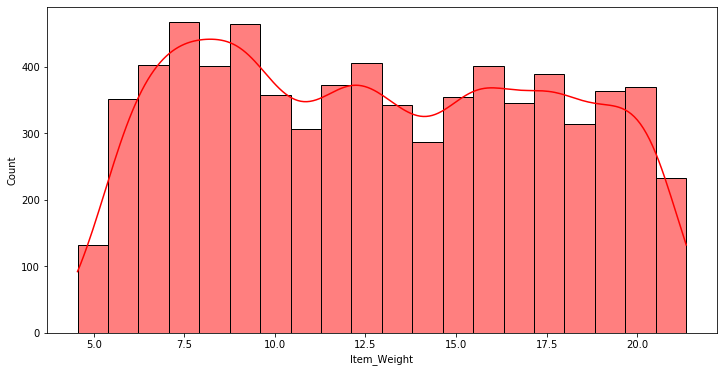

Mean =  12.857645184136183 ; Median =  12.6 ; Mode =  12.15


In [17]:
#distribution of Item weight

plt.figure(figsize=(12,6))
sns.histplot(data=train_df,x='Item_Weight',kde=True,color='red')
plt.show()
print("Mean = ",train_df['Item_Weight'].mean(),"; Median = ",train_df['Item_Weight'].median(),"; Mode = ",train_df['Item_Weight'].mode()[0])

* There are no anomallies in the column Item_Weight; Also the distribution is almost normal so the null value can be substituted with mean.

In [18]:
# mean value of "Item_Weight" column
train_df['Item_Weight'].mean()

12.857645184136183

In [19]:
# filling the missing values in "Item_weight column" with "Mean" value
train_df['Item_Weight'].fillna(train_df['Item_Weight'].mean(), inplace=True)

In [20]:
# mean value of "Item_Weight" column
test_df['Item_Weight'].mean()

12.695633368756374

In [21]:
# filling the missing values in "Item_weight column" with "Mean" value
test_df['Item_Weight'].fillna(train_df['Item_Weight'].mean(), inplace=True)

In [22]:
def barplot_null(dataframe):
    dataframe["Outlet_Size_Null"]=np.where(dataframe["Outlet_Size"].isnull(),"Null",dataframe["Outlet_Size"])
    numerical_features=[feature for feature in dataframe.columns if dataframe[feature].dtypes != 'O']
    discrete_features=[feature for feature in numerical_features if dataframe[feature].nunique() <25 ]
    continous_features=[feature for feature in numerical_features if feature not in discrete_features]
    for feature in continous_features[1:]:
        plt.figure(figsize=(12,6))
        sns.barplot(data=train_df,
                    x="Outlet_Size_Null",
                    y=feature,
                    palette="rainbow",
                    order= dataframe.groupby(["Outlet_Size_Null"])[feature].mean().sort_values().index)
        plt.show()

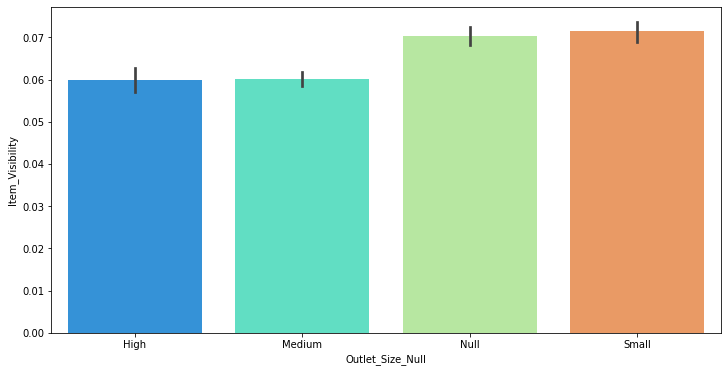

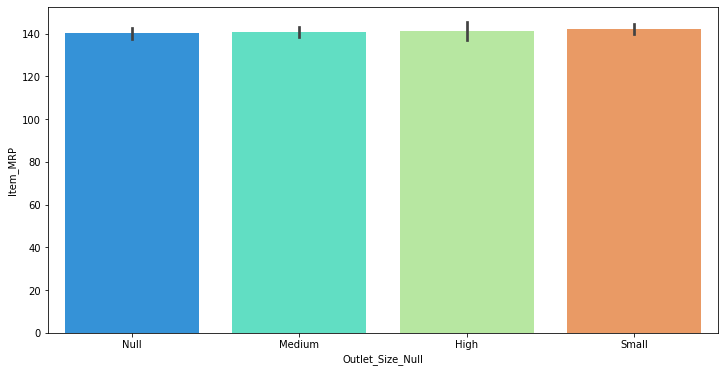

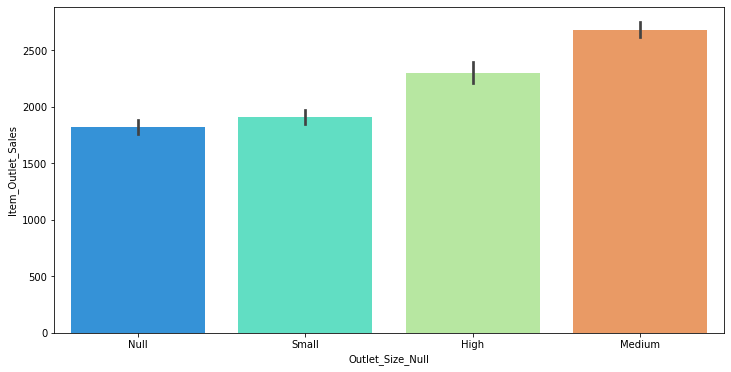

In [23]:
barplot_null(train_df)
train_df.drop('Outlet_Size_Null',axis=1,inplace=True)

* Null Value is similar to small outlet.

In [24]:
train_df["Outlet_Size"].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [25]:
test_df["Outlet_Size"].value_counts()

Medium    1862
Small     1592
High       621
Name: Outlet_Size, dtype: int64

* since the null has similar feature/relation as small we are going to substitute it as small.

In [26]:
train_df['Outlet_Size']= train_df['Outlet_Size'].fillna('Small')
test_df['Outlet_Size']= test_df['Outlet_Size'].fillna("Small")

In [27]:
train_df.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [28]:
test_df.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

### Cleaning the Data

In [29]:
train_df["Item_Fat_Content"].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [30]:
test_df["Item_Fat_Content"].value_counts()

Low Fat    3396
Regular    1935
LF          206
reg          78
low fat      66
Name: Item_Fat_Content, dtype: int64

In [31]:
train_df["Item_Fat_Content"]=np.where((train_df["Item_Fat_Content"] == 'Low Fat')|(train_df["Item_Fat_Content"] == 'LF')|(train_df["Item_Fat_Content"] == 'low fat'),"Low Fat","Regular")

In [32]:
#calculating outlet age from establishment year
train_df['Outlet_Age']=(2021-train_df['Outlet_Establishment_Year']).astype('str')

In [33]:
test_df["Item_Fat_Content"]=np.where((test_df["Item_Fat_Content"] == 'Low Fat')|(test_df["Item_Fat_Content"] == 'LF')|(test_df["Item_Fat_Content"] == 'low fat'),"Low Fat","Regular")

In [34]:
#calculating outlet age from establishment year
test_df['Outlet_Age']=(2021-test_df['Outlet_Establishment_Year']).astype('str')

In [35]:
train_df.drop("Outlet_Establishment_Year",axis=1,inplace=True)
test_df.drop("Outlet_Establishment_Year",axis=1,inplace=True)

## EDA

### Univariate Analaysis

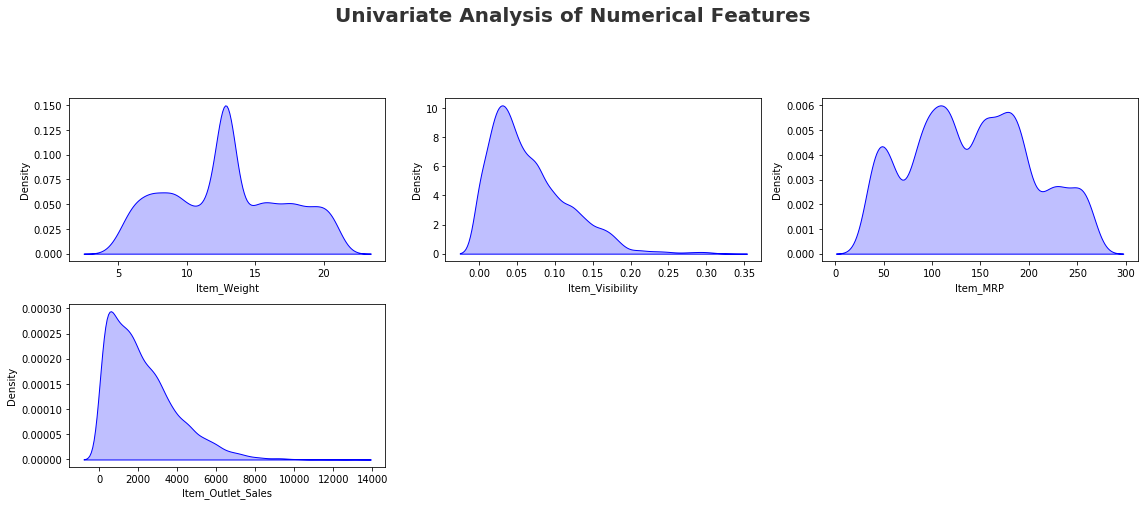

In [36]:
numeric_features=[feature for feature in train_df.columns if train_df[feature].dtypes != 'O']

plt.figure(figsize=(16, 14))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.08)

for i in range(0, len(numeric_features)):
    plt.subplot(5, 3, i+1)
    sns.kdeplot(x=train_df[numeric_features[i]],shade=True, color='b')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

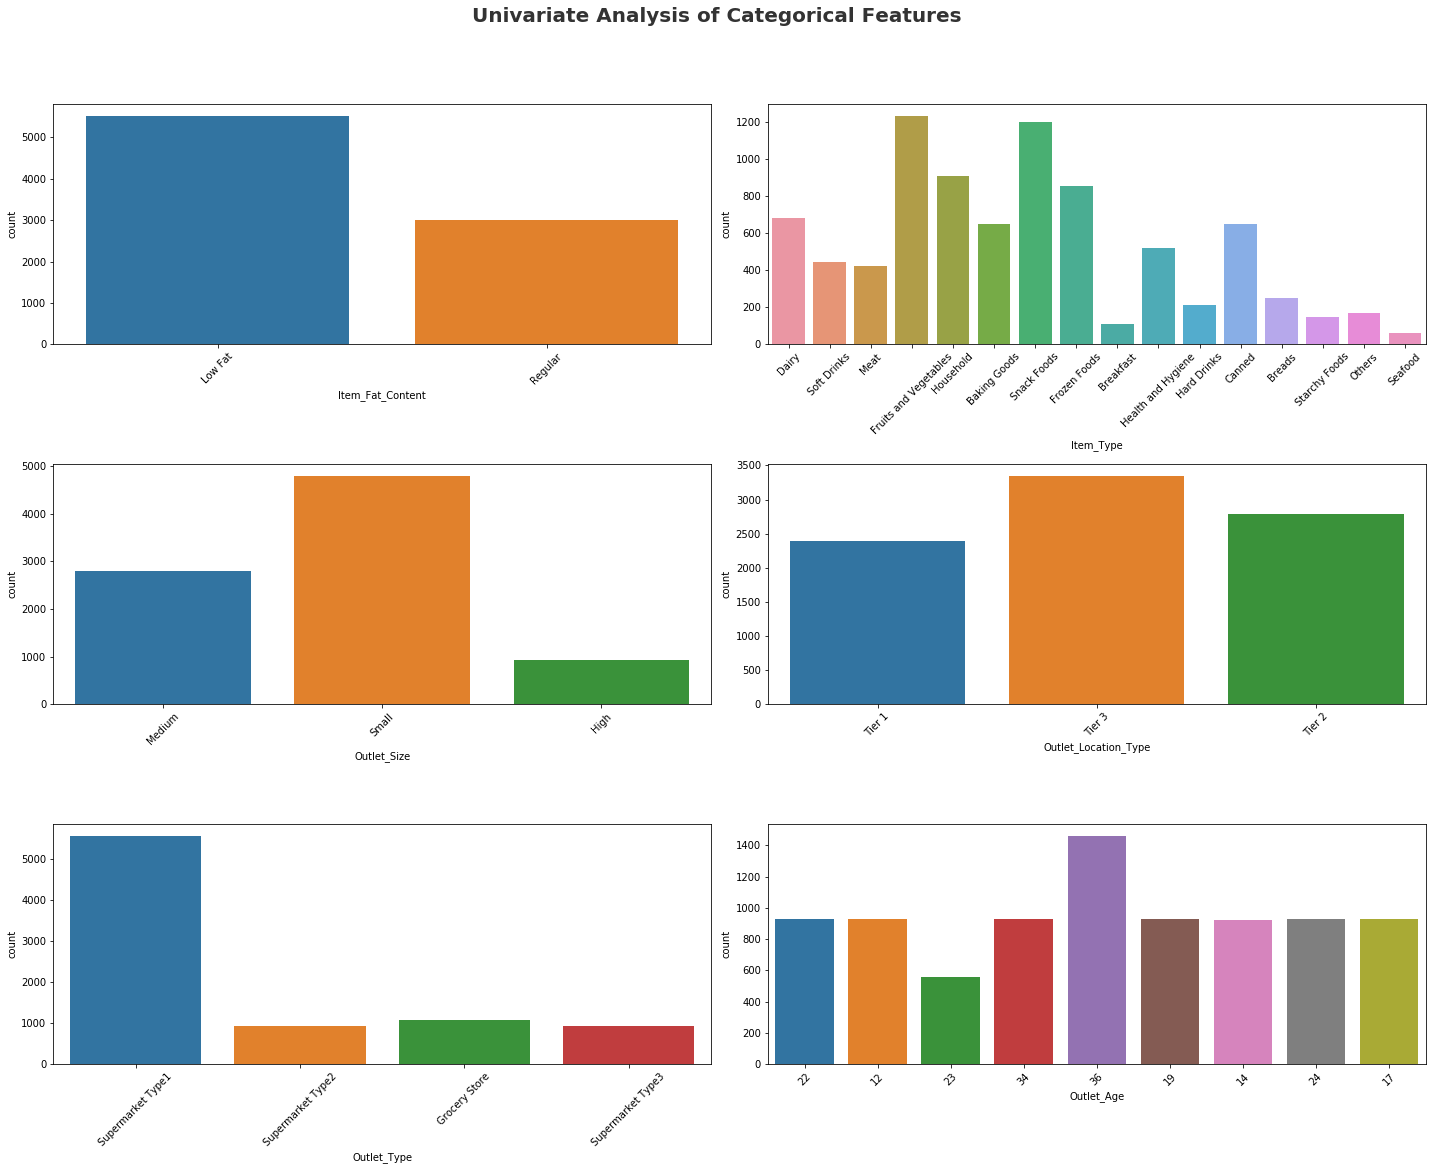

In [37]:
# categorical columns
categorical_features=[feature for feature in train_df.columns if train_df[feature].dtypes == 'O']
plt.figure(figsize=(20, 15))
plt.suptitle('Univariate Analysis of Categorical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.08)
for i in range(0, len(categorical_features)):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=train_df[categorical_features[i]])
    plt.xlabel(categorical_features[i])
    plt.xticks(rotation=45)
    plt.tight_layout()

### outlier

Number of Outlier in the column Item_Weight is 0


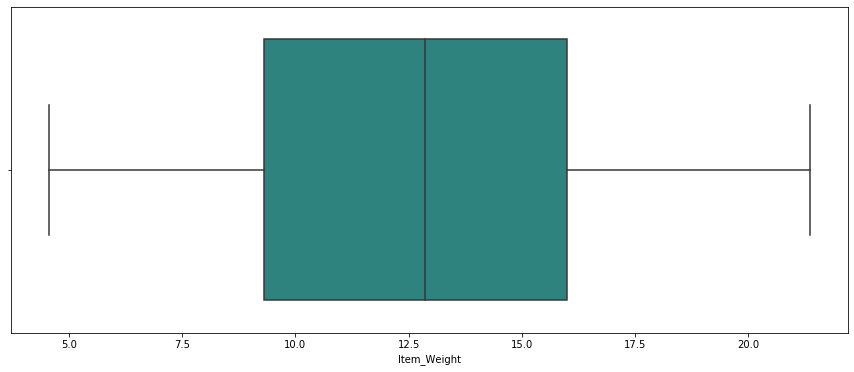

Number of Outlier in the column Item_Visibility is 144


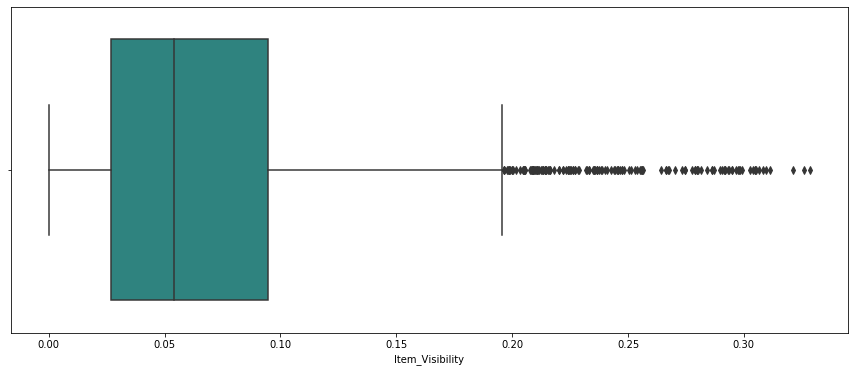

Number of Outlier in the column Item_MRP is 0


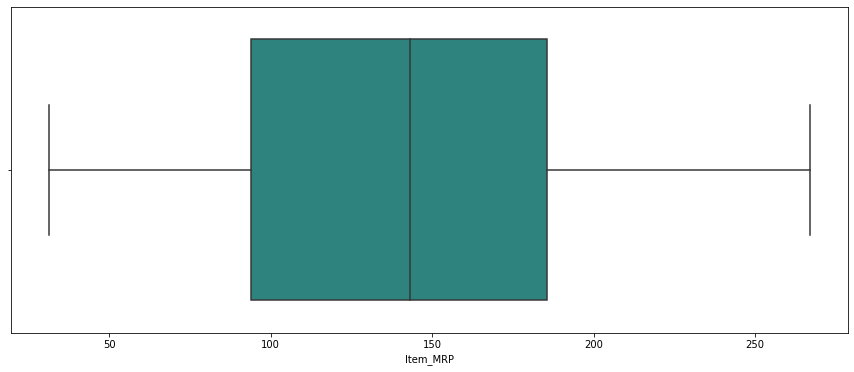

Number of Outlier in the column Item_Outlet_Sales is 186


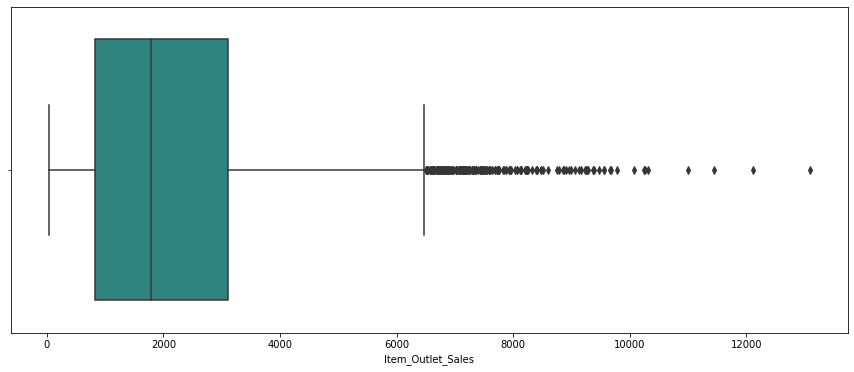

In [38]:
discrete_features=[feature for feature in numeric_features if train_df[feature].nunique() <25 ]
continous_features=[feature for feature in numeric_features if feature not in discrete_features]
for feature in continous_features:
    IQR=np.nanquantile(train_df[feature],.75)-np.nanquantile(train_df[feature],.25)
    right_whisker=1.5*IQR+np.nanquantile(train_df[feature],.75)
    left_whisker=np.nanquantile(train_df[feature],.25)-1.5*IQR
    outlier_count=(train_df[feature]>right_whisker).sum() + (train_df[feature]<left_whisker).sum()
    print(f"Number of Outlier in the column {feature} is {outlier_count}")
    plt.figure(figsize=(15,6))
    sns.boxplot(data=train_df,x=feature,palette="viridis")
    plt.show()

Number of Outlier in the column Item_Weight is 0


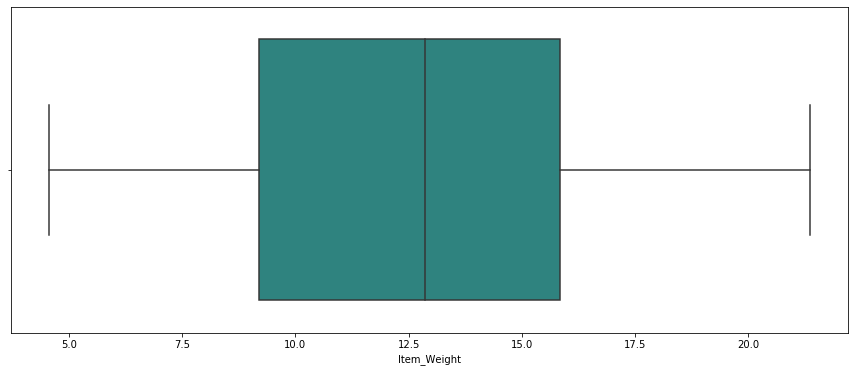

Number of Outlier in the column Item_Visibility is 113


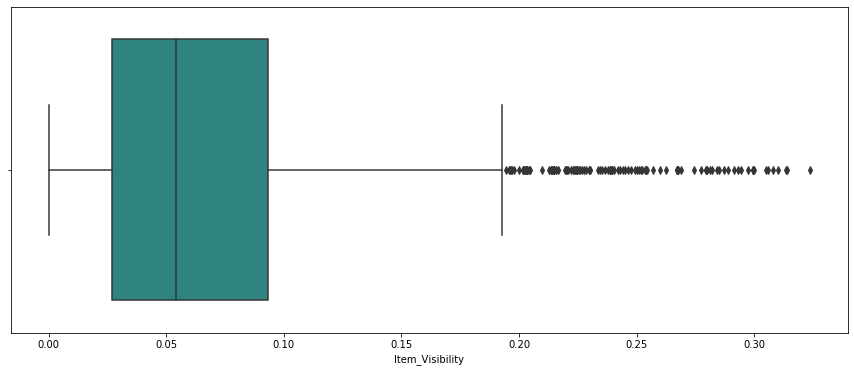

Number of Outlier in the column Item_MRP is 0


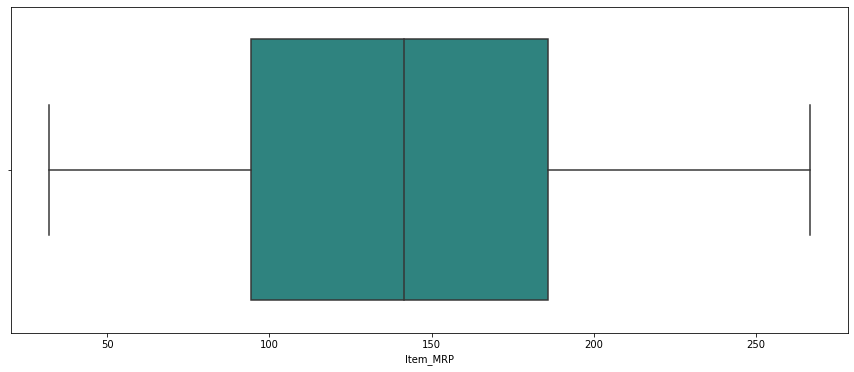

In [39]:
numerical_features=[feature for feature in test_df.columns if test_df[feature].dtypes != 'O']
discrete_features=[feature for feature in numerical_features if test_df[feature].nunique() <25 ]
continous_features=[feature for feature in numerical_features if feature not in discrete_features]

for feature in continous_features:
    IQR=np.nanquantile(test_df[feature],.75)-np.nanquantile(test_df[feature],.25)
    right_whisker=1.5*IQR+np.nanquantile(test_df[feature],.75)
    left_whisker=np.nanquantile(test_df[feature],.25)-1.5*IQR
    outlier_count=(test_df[feature]>right_whisker).sum() + (test_df[feature]<left_whisker).sum()
    print(f"Number of Outlier in the column {feature} is {outlier_count}")
    plt.figure(figsize=(15,6))
    sns.boxplot(data=test_df,x=feature,palette="viridis")
    plt.show()

## Pre-processing


### Dealing with Outliers

In [40]:
z1 = np.abs(stats.zscore(train_df["Item_Outlet_Sales"]))
for i in (np.where(z1>3)):
    train_df.drop(i,inplace=True)
train_df.set_index( np.arange(8433),inplace=True )
z2 = np.abs(stats.zscore(train_df["Item_Visibility"]))
for i in (np.where(z2>3)):
    train_df.drop(i,inplace=True)
train_df.set_index( np.arange(8338),inplace=True )

In [41]:
z3 = np.abs(stats.zscore(test_df["Item_Visibility"]))
for x in (np.where(z3>3)):
    test_df.drop(x,inplace=True)
test_df.set_index( np.arange(5600),inplace=True )

### Checking correlation

In [42]:
train_df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
Item_Weight,1.000000,-0.009761,0.024233,0.010671
Item_Visibility,-0.009761,1.000000,0.000153,-0.091955
Item_MRP,0.024233,0.000153,1.000000,0.569544
Item_Outlet_Sales,0.010671,-0.091955,0.569544,1.000000


### Dealing with the Categorical Variables

In [43]:
y = train_df['Item_Outlet_Sales'].to_frame(name='Target')
X = train_df.drop('Item_Outlet_Sales', axis=1)
test = test_df.copy()

In [44]:
for feature in categorical_features:
        label = preprocessing.LabelEncoder()
        X[feature] = label.fit_transform(X[feature])
        test[feature] = label.transform(test[feature])

In [45]:
X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age
0,9.30,0,0.016047,4,249.8092,1,0,1,4
1,5.92,1,0.019278,14,48.2692,1,2,2,0
2,17.50,0,0.016760,10,141.6180,1,0,1,4
3,19.20,1,0.000000,6,182.0950,2,2,0,5
4,8.93,0,0.000000,9,53.8614,0,2,1,7


## Create Functions for model training and evaluation

In [49]:
# df to store model error and scores
model_scores = pd.DataFrame(columns=['model', 'rmse', 'r2_score', 'mae'])

In [65]:
def train_and_evaluate_model(model_name, model, X, y):
    '''
    Create a training pipeline to scale and train the model
    using the input data, then evaluate the model and safe its error
    and score in the scores dataframe.
    '''
    # split the data
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # create a training pipeline
    pipeline = make_pipeline(StandardScaler(), model)
    
    # apply scaling on training data and train the model
    pipeline.fit(X_train, y_train)
    
    # predict the validation set
    y_test_pred = pipeline.predict(X_validate)
    y_train_pred = pipeline.predict(X_train)
    
    # evaluate the model
    r2_score_train = r2_score(y_train, y_train_pred)
    rmse = np.sqrt(mean_squared_error(y_validate, y_test_pred))
    model_score = r2_score(y_validate, y_test_pred)
    mae = mean_absolute_error(y_validate, y_test_pred)
    
    # adding error and score, to the scores datafrane
    model_scores.loc[len(model_scores)] = [model_name, rmse, model_score, mae]
    
    print('----------------------------------')
    print(model_name, ' Report:')
    print('----------------------------------')
    print('   Train data ')
    print('R2 Score: ', r2_score_train)
    print('----------------------------------')
    print('   Test data  ')
    print('RMSE: ', rmse)
    print('R2 Score: ', model_score)
    print('MAE: ', mae)
    

In [66]:
# linear regression
linear_regression_model = LinearRegression()
train_and_evaluate_model('Linear Regression', linear_regression_model, X, y)

----------------------------------
Linear Regression  Report:
----------------------------------
   Train data 
R2 Score:  0.49154220037064766
----------------------------------
   Test data  
RMSE:  1140.5229393130783
R2 Score:  0.4828982356012578
MAE:  877.0810026881132


In [67]:
#RnadomForest regression
random_forest_model = RandomForestRegressor()
train_and_evaluate_model('RandomForest Regression', random_forest_model, X, y)

----------------------------------
RandomForest Regression  Report:
----------------------------------
   Train data 
R2 Score:  0.9352353716709672
----------------------------------
   Test data  
RMSE:  1075.6193552294765
R2 Score:  0.5400769376205081
MAE:  767.7921736342925


In [56]:
#Decision Tree Regressor
Decision_tree_model= DecisionTreeRegressor()
train_and_evaluate_model('Decision Tree', Decision_tree_model, X, y)

----------------------------------
Decision Tree  Report:
----------------------------------
   Train data 
R2 Score:  1.0
----------------------------------
   Test data  
RMSE:  1462.9460137306085
R2 Score:  0.14920570298094837
MAE:  1030.7657742206236


In [57]:
#AdaBoost Classifier
AdaBoost_regressor = AdaBoostRegressor()
train_and_evaluate_model('AdaBoost Regressor', AdaBoost_regressor, X, y)

----------------------------------
AdaBoost Regressor  Report:
----------------------------------
   Train data 
R2 Score:  0.5698446259765807
----------------------------------
   Test data  
RMSE:  1041.2637189638112
R2 Score:  0.568987919191347
MAE:  778.4875278134355


In [58]:
#KNNeighbors Regressor
knn_regressor = KNeighborsRegressor()
train_and_evaluate_model("KNNR", knn_regressor, X, y)

----------------------------------
KNNR  Report:
----------------------------------
   Train data 
R2 Score:  0.6778774288848566
----------------------------------
   Test data  
RMSE:  1128.2195847922965
R2 Score:  0.4939944980468137
MAE:  812.6548034772183


In [59]:
#SVR
svr = SVR()
train_and_evaluate_model('SVR',svr,X,y)

----------------------------------
SVR  Report:
----------------------------------
   Train data 
R2 Score:  0.06844472540383861
----------------------------------
   Test data  
RMSE:  1526.8964456209242
R2 Score:  0.07319762384392492
MAE:  1165.320696543408


In [ ]:
train_df['Item_Outlet_Sales'].value_counts()

In [ ]:
#AdaBoost Classifier
AdaBoost_regressor = AdaBoostRegressor(base_estimator=Decision_tree_model,
                                   n_estimators=100,
                                   learning_rate=0.005,
                                   random_state=42)
train_and_evaluate_model('AdaBoost Regressor', AdaBoost_regressor, X, y)

In [ ]:
y_train.value_counts()

In [ ]:
y_validate.value_counts()